# Design Space Exploration Plugin

## Basics

The design plugin `tidy3d.plugins.design` is a wrapper that makes it simple and convenient for `tidy3d` users to define experiments to systematically explore a design space.

In short, users define the dimensions of their design problem, as well as the method they wish to explore the design space. These specifications are combined in a `DesignSpace` object.

Then, the user passes a function that defines the input / output relationship they wish to explore. The function arguments correspond to the dimensions defined in the `DesignSpace` and the function outputs can be anything.

The resulting data is stored as a `Result` object, which has its own methods but can be easily converted to a `pandas.DataFrame` for analysis, post processing, or visualization. The columns in this `DataFrame` correspond to the function inputs and outputs and each data point corresponds to a row in this `DataFrame`.

For reference, here is a diagram of the entire process.

<img src="img/design.png" alt="sweep" width="800"/>

For another example of the `design` plugin used in practice, see about halfway down our [parameter scan notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/ParameterScan). See the use of the `design` plugin in a practical case study, see the [all-dielectric structural color notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/AllDielectricStructuralColor/).

> Note: this feature is in pre-release stage. if you have questions or suggestions for the API, please feel free to make an issue on our [github page](https://github.com/flexcompute/tidy3d).

The plugin is imported from `tidy3d.plugins.design` so it's convenient to import this namespace first along with the other packages we need.

In [1]:
import numpy as np
import matplotlib.pylab as plt
import typing

import tidy3d as td
import tidy3d.web as web
import tidy3d.plugins.design as tdd

## Quickstart

While the `design` plugin is built on `Tidy3D` and has special features for handling FDTD simulations, it can also be run with any general design problem. Here is a quick, complete example before diving into the use of the plugin with `Tidy3D` simulations.

Here we want to sample a design space with two dimensions `x` and `y` with Monte Carlo. Our function simply returns a Gaussian centered at `(0,0)` and we'll evaluate the result for Gaussians with 3 different variances.

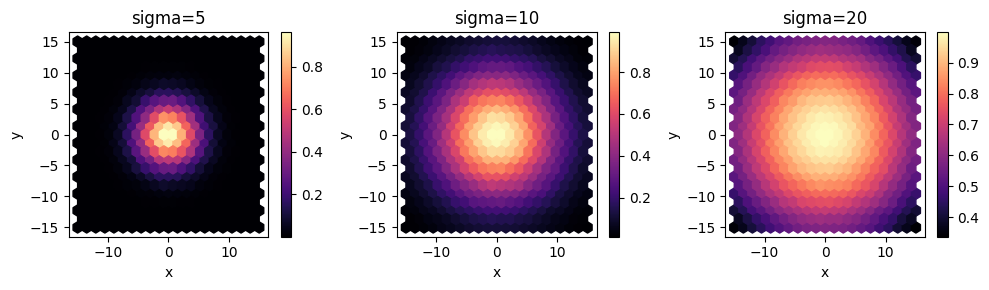

In [2]:
# define your design space (parameters (x,y) within certain ranges)
param_x = tdd.ParameterFloat(name="x", span=(-15,15))
param_y = tdd.ParameterFloat(name="y", span=(-15,15))

# define your sampling method, Monte Carlo method with 10,000 points
method = tdd.MethodMonteCarlo(num_points=10000)

# put everything together in a `DesignSpace` container
design_space = tdd.DesignSpace(method=method, parameters=[param_x, param_y])

# define your figure of merit function. Here we compute a gaussian as a function of x and y with different values for the width.
sigmas = {f"sigma={s}": s for s in [5, 10, 20]}
def f(x:float, y:float) -> typing.Dict[str, float]:
    """gaussian distribution as a function of x and y."""
    r2 = x**2 + y**2
    gaussian = lambda sigma: np.exp(-r2 / sigma ** 2)
    # return a dictionary, where the key is used to label the output names
    return {key: gaussian(sigma) for key, sigma in sigmas.items()}

# note, we return a dictionary here, they keys correspond to our output data labels
# in the future, this function will involve running tidy3d simulations

# .run the design on our function and convert the results to a pandas.DataFrame
df = design_space.run(f).to_dataframe()

# plot the results using pandas.DataFrame builtins
f, axes = plt.subplots(1, 3, figsize=(10, 3), tight_layout=True)
for ax, C in zip(axes, sigmas.keys()):
    _ = df.plot.hexbin(x='x', y='y', gridsize=20, C=C, cmap="magma", ax=ax)
    ax.set_title(C)


In [3]:
# look at the first 5 outputs
df.head()

,x,y,sigma=5,sigma=10,sigma=20
0,0.671337,8.081672,0.072038,0.518072,0.848394
1,5.863455,14.399243,0.000063,0.089172,0.546459
2,-5.293638,4.528466,0.143534,0.615515,0.885747
3,-6.000587,2.748947,0.175073,0.646852,0.896812
4,4.837346,-7.166397,0.050273,0.473515,0.829533


##  Design Space Exploration in Tidy3D

This is essentially the same process that we will use to perform a parameter sweep of a photonic device. The only difference is that our function evaluation each point will involve a `tidy3d` simulation.

For a concrete example, let's analyze the transmission of a 1D multilayer slab. Our system will have `num` layers with refractive index alternating between two values, each with thickness `t`. We write a function to compute the transmitted flux through this system at frequency `freq0` as a function of `num` and `t`.

In [4]:
lambda0 = 0.63
freq0 = td.C_0 / lambda0

mnt_name = "flux"
buffer = 1.5 * lambda0

refractive_indices = [1.5, 1.2]


Let's write our measurement function, for convenience, we'll break it into pre-processing and post-processing functions. The pre-processing function returns a `tidy3d.Simulation` as a function of the input parameters and the post-processing function returns the transmitted flux as a function of the `tidy3d.SimulationData` associated with the simulation.

In [5]:
def pre(num: int, t: float) -> td.Simulation:
    """Pre-processing function, which creates a tidy3d simulation given the function inputs."""
    layers = []
    z = 0
    for i in range(num):
        n = refractive_indices[i % len(refractive_indices)]
        thickness = t * lambda0 / n
        medium = td.Medium(permittivity = n ** 2)
        geometry = td.Box(center=(0, 0, z + thickness / 2), size=(td.inf, td.inf, thickness))
        layers.append(td.Structure(geometry=geometry, medium=medium))
        z += thickness
    Lz = z + 2 * buffer
    sim = td.Simulation(
        size=(0, 0, Lz),
        center=(0, 0, z / 2),
        structures=layers,
        sources=[td.PlaneWave(
            size=(td.inf, td.inf, 0),
            center=(0, 0, -buffer * 0.75),
            source_time=td.GaussianPulse(freq0=freq0, fwidth=freq0/10),
            direction="+",
        )],
        monitors=[td.FluxMonitor(
            size=(td.inf, td.inf, 0),
            center=(0, 0, z + buffer * 0.75),
            freqs=[freq0],
            name=mnt_name,
        )],
        boundary_spec=td.BoundarySpec.pml(x=False, y=False, z=True),
        run_time=100 / freq0,
    )
    return sim

def post(data: td.SimulationData) -> dict:
    """Post-processing function, which processes the tidy3d simulation data to return the function output."""
    flux = np.sum(data['flux'].flux.values)
    return {"flux": flux}

> Note: if we were to write the full transmission function using pre and post it would look like the function below. However, the sweep plugin will handle running the simulation for us, as we'll see later.

```python
def transmission(num: int, t: float) -> float:
    """Transmission as a function of number of layers and their thicknesses.
         Note: not used, just a demonstration of how the pre and post functions are related.
    """
    sim = pre(num=num, t=t)
    data = web.run(sim, task_name=f"num={num}_t={t}")
    return post(data=data)
```



> Note: we choose to have our post-processing function return a dictionary `{"flux": flux}` instead of just a `float`. If a dictionary is returned, the `design` plugin will use the keys to label the dataset outputs, otherwise it will use defaults, so this approach is slightly cleaner.


Let's visualize the simulation for some example parameters to make sure it looks ok.

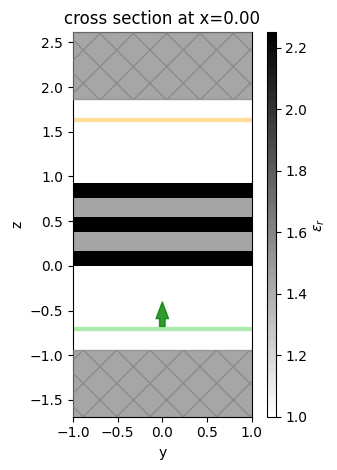

In [6]:
sim = pre(num=5, t=0.4)
ax = sim.plot_eps(x=0, hlim=(-1, 1))


##  Parameters

If we want, we could query these functions directly to perform our own parameter scan, but the utility of the `design` plugin is that it lets us simply **define** our design problem as a specification and then takes care of all of the accounting for us.

The first step is to define the design "parameters" (or dimensions), which also serve as inputs to our function defined earlier.

In this case, we have a parameter `num`, which is a non-negative integer and a parameter `t`, which is a positive float.

We can construct a named `tdd.Parameter` for each of these and define some spans as well.

In [7]:
param_num = tdd.ParameterInt(name='num', span=(1, 5))
param_t = tdd.ParameterFloat(name='t', span=(0.1, 0.5), num_points=5)

Note that the `name` fields should correspond to the argument names defined in the function.

The float parameter takes an optional `num_points` option, which tells the design tool how to discretize the continuous dimension only when doing a grid sweep. For random or Monte Carlo sweeps, it is not used.

Also, it is possible to define parameters that are simply sets of quantities that we might want to select using `allowed_values`, such as:

In [8]:
param_str = tdd.ParameterAny(name="some_string", allowed_values=("these", "are", "values"))

but we will ignore this case as it's not needed here and the internal logic is similar to that for integer parameters.

> Note: to do more complex sets of integer parameters (like skipping every 'n' integers). We recommend simply using `ParameterAny` and just passing your integers to `allowed_values`.

By defining our design parameters like this, we can more concretely define what types and allowed values can be passed to each argument in our function for the parameter sweep.

##  Method

Now that we've defined our parameters, we also need to define the procedure to use to sample the parameter space we've defined. One approach is to independently sample points within the parameter spans, for example using a Monte Carlo method, another is to perform a grid search to uniformly scan between the bounds of each dimension. There are also more complex methods, such as Bayesian optimization and gradient-based optimization, which will be introduced in future releases.

In the `design` plugin, we define the specifications for the parameter sweeps using `Method` objects.

Here's one example, which defines a grid search.

In [9]:
method = tdd.MethodGrid()

For this example, let's instead do a random (Monte Carlo) sampling with a set number of points.

> Note: the default Monte Carlo uses the [Latin hypercube sampling](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.qmc.LatinHypercube.html) method to sample the space. One can also pass an object with a `.random()` method to the `sampler` keyword argument of `MethodRandomCustom` for more customization. Other Monte Carlo methods from the `scipy` [quasi-Monte Carlo](https://docs.scipy.org/doc/scipy/reference/stats.qmc.html) engines work well for this and provide more flexibility.

In [10]:
method = tdd.MethodMonteCarlo(num_points=40)

## Design Space

With the design parameters and our method defined, we can combine everything into a `DesignSpace`, which is mainly a container that provides some higher level methods for interacting with these objects.

In [11]:
design_space = tdd.DesignSpace(parameters=[param_num, param_t], method=method)

Now we need to pass our transmission function to the `DesignSpace` object to get our results.

To start the parameter scan, the `DesignSpace` has two methods `.run()` and `.run_batch()`, which accept our function(s) defined earlier in the following ways.

1. `DesignSpace.run(transmission)` samples the design parameters according to the `method` and then evaluates each point one by one. This is the most general approach because `transmission` is not restricted to any relationships regarding `Simulation` and `SimulationData` . Because of this, we can't make any assumptions about whether `transmission` can be parallelized and will need to call it sequentially for each point in the parameter scan.

2. On the other hand, `DesignSpace.run_batch(pre, post)` accepts our pre and post processing functions. Because it can assume that one or many simulations are created and run in between, this method can safely construct a `web.Batch` under the hood and run all of the the tasks in parallel over the parameter sweep points. The final results are then stitched together in the end.

> Note: the pre processing function can return a single `Simulation`, a `list` or `tuple` of `Simulation`s or a `dict` containing `Simulation`s. The user just needs to be sure that the post processsing function accepts the corresponding `SimulationData`, `*args` of `SimulationData` or `**kwargs` of `SimulationData`, respectively. For example if `dict(a=sim1, b=sim2)` is returned by the pre-processing function, the post-processing function must have a signature of `def fn_post(a, b)`.

## Results

The `DesignSpace.run()` and `DesignSpace.run_batch()` functions described before both return a `Result` object, which is basically a dataset containing the function inputs, outputs, source code, and any task ID information corresponding to each data point.

> Note that task ID information can only be gathered when using `run_batch` because in the more general `run()` function, `tidy3d` can't know which tasks were involved in each data point.

In [12]:
results = design_space.run_batch(pre, post)

Output()

12:13:12 UTC Started working on Batch containing 40 tasks.

12:13:40 UTC Maximum FlexCredit cost: 1.000 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

12:14:18 UTC Batch complete.

Output()

> Note: we can pass `verbose=False` to the `run_batch()` function to turn off outputs for large batches.

`Results` contains three main related datastructures.

* `dims`, which correpsond to the `kwargs` of the pre-processing function, `('num', 't')` here.

* `coords`, which is a tuple containing the values passed in for each of the dims. `coords[i]` is a tuple of `n`, and `t` values for the `i`th function call.

* `values`, which is a tuple containing the outputs of the postprocessing functions. In this case `values[i]` stores the transmission of the `i`th function call.

The `Results` can be converted to a `pandas.DataFrame` where each row is a separate data point and each column is either an input or output for a function. It also contains various methods for plotting and managing the data.

> Note: if the measurement function returns a dictionary, the keys will be used as labels for the columns in the `DataFrame`. If it returns a `tuple` or `list`, each element will get a unique key assigned to them in the `DataFrame` depending on the index.

In [13]:
# The first 5 data points
df = results.to_dataframe()
df.head()

,num,t,flux
0,1,0.400450,0.958654
1,2,0.357040,0.922977
2,4,0.236619,0.827258
3,4,0.270790,0.840717
4,1,0.211584,0.862932


The `pandas` [documentation](https://pandas.pydata.org/docs/getting_started/intro_tutorials/01_table_oriented.html#min-tut-01-tableoriented) provides excellent explanations of the various postprocessing and visualization functions that can be used.

/home/flexcompute_ci/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/flexcompute_ci/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


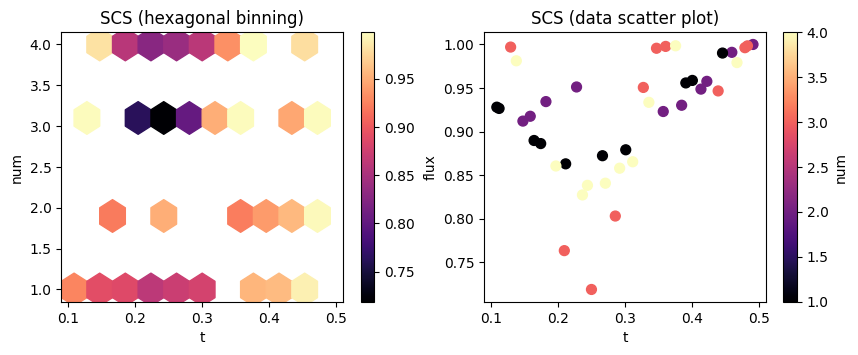

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3.5))

# plot a hexagonal binning of the results
im = df.plot.hexbin(x="t", y="num", gridsize=10, C="flux", cmap="magma", ax=ax1)
ax1.set_title('SCS (hexagonal binning)')

# scatterplot the raw results with flux on the y axis
im = df.plot.scatter(x="t", y="flux", s=50, c="num", cmap="magma", ax=ax2)
ax2.set_title('SCS (data scatter plot)')

plt.show()

Note, these functions just call `pandas.DataFrame` plotting under the hood, so it is worth referring to the [docs page on DataFrame visuazation](https://pandas.pydata.org/docs/user_guide/visualization.html) for more tips on plotting design problem results.

### Modifying Results

After the design problems is run, one might want to modify the results through adding or removing elements or combining different results. Here we will show how to perform some of these advanced features in the `design` plugin.

#### Combining Results

We can combine the results of two separate design problems assuming they were created with the same functions.

This can be done either with `result.combine(other_result)` or with a shorthand of `result + other_result`.

In this example, let's say we want to explore more the region where the transmission seems to be lowest, for `t` between 0.2 and 0.3. We create a new parameter with the desired span for `t` and use it to create an updated copy of the previous design, still using the same method.

In [15]:
param_t2 = tdd.ParameterFloat(name='t', span=(0.2, 0.3), num_points=5)
design_space2 = design_space.updated_copy(parameters=[param_num, param_t2])
results2 = design_space2.run_batch(pre, post)

Output()

12:14:48 UTC Started working on Batch containing 40 tasks.

12:15:19 UTC Maximum FlexCredit cost: 1.000 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

12:15:44 UTC Batch complete.

Output()

Now we can inspect the new results and the combined data as we did before:

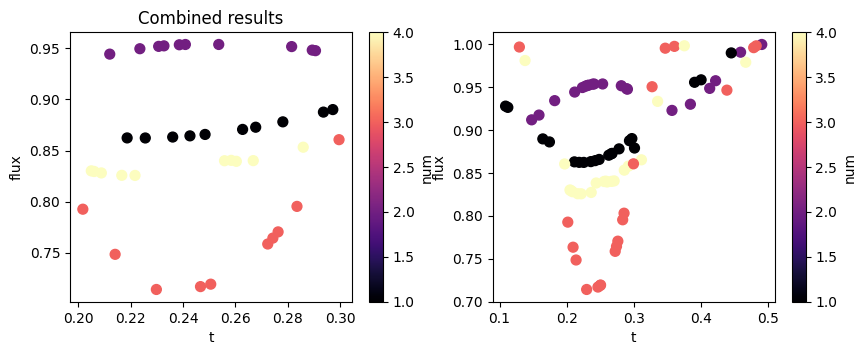

In [16]:
results_combined = results + results2

df2 = results2.to_dataframe()
df_combined = results_combined.to_dataframe()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3.5))

im = df2.plot.scatter(x="t", y="flux", s=50, c="num", cmap="magma", ax=ax1)
ax1.set_title('Second run')

im = df_combined.plot.scatter(x="t", y="flux", s=50, c="num", cmap="magma", ax=ax2)
ax1.set_title('Combined results')

plt.show()

We can also change the method if we want…

In [17]:
# make another set of results using the same function and design but different method
design_space3 = design_space.updated_copy(method=tdd.MethodRandom(num_points=2, monte_carlo_warning=False))
results3 = design_space3.run_batch(pre, post)

Output()

12:16:07 UTC Started working on Batch containing 2 tasks.

12:16:09 UTC Maximum FlexCredit cost: 0.050 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

12:16:27 UTC Batch complete.

Output()

… and combine the third run to the previous (now using the `combine` method, which is equivalent to adding both):

In [18]:
all_results = results_combined.combine(results3)

print(all_results == results + results2 + results3)

True


#### Adding and removing results

We can also add and remove individual entries from the `Results` with the `add` and `delete` methods.

Let's add a new data point to our results and then delete it.

In [19]:
# define the function inputs and outputs
fn_args = {"t": 1.2, "num": 5}
value = 1.9

To add a data element, we pass in the `fn_args` (inputs) and the `value` (outputs).

In [20]:
# add it to the results and view the last 5 entries (data is present)
results = results.add(fn_args=fn_args, value=value)
results.to_dataframe().tail()

,num,t,flux
36,1,0.108944,0.927961
37,3,0.209573,0.763365
38,4,0.244059,0.838274
39,3,0.438892,0.946599
40,5,1.200000,1.900000


We can select a specific data point by passing the function inputs as keyword arguments to the `Results.sel` method.

In [21]:
print(results.sel(**fn_args))

1.9


Similarly, we can remove a data point by passing the `fn_args` (inputs) to the `Results.delete` method.

In [22]:
# remove this data from the results and view the last 5 entries (data is gone)
results = results.delete(fn_args=fn_args)
results.to_dataframe().tail()

,num,t,flux
35,1,0.174348,0.886201
36,1,0.108944,0.927961
37,3,0.209573,0.763365
38,4,0.244059,0.838274
39,3,0.438892,0.946599


#### Leveraging DataFrame functions

Since we have the ability to convert the `Results` to and from `pandas.DataFrame` objects, we are able to perform various manipulations (including the ones above) on the data using `pandas`. For example, we can create a new `DataFrame` object that multiplies all of the original `flux` values by 1/2 and convert this back to a  `Result` if desired.

In [23]:
df = results.to_dataframe()
df.head()

,num,t,flux
0,1,0.400450,0.958654
1,2,0.357040,0.922977
2,4,0.236619,0.827258
3,4,0.270790,0.840717
4,1,0.211584,0.862932


In [24]:
# get a dataframe where everything is squared
df_half_flux = df.copy()
df_half_flux["flux"] = df_half_flux["flux"].map(lambda x: x * 0.5)
df_half_flux.head()

,num,t,flux
0,1,0.400450,0.479327
1,2,0.357040,0.461488
2,4,0.236619,0.413629
3,4,0.270790,0.420359
4,1,0.211584,0.431466


We generally recommend you make use of the many features provided by `pandas.DataFrame` to do further postprocessing and analysis of your sweep results, but to convert a `DataFrame` back to a `Result`, one can simply pass it to `Results.from_dataframe` along with the dimensions of the data (if the `DataFrame` has been modified).

In [25]:
# load it into a Result, note that we need to pass dims because this is an entirely new DataFrame without metadata
results_squared = tdd.Result.from_dataframe(df_half_flux, dims=("num", "t"))

### Accessing the batch data

Finally, if `Design.run_batch()` was used, then the `Result` object also stores the `BatchData` associated with the design run.

It can be accessed and iterated through as follows.

In [26]:
batch_data = results.batch_data
batch_data = batch_data.updated_copy(verbose=False)

flux_dict = {}
for task_name, sim_data in batch_data.items():
    flux = np.sum(sim_data['flux'].flux.values)
    flux_dict[task_name] = flux

In [27]:
from pprint import pprint
pprint(flux_dict)

{"{'num': 1, 't': 0.10894399611099503}": 0.9279607,
 "{'num': 1, 't': 0.1123157085689373}": 0.9264997,
 "{'num': 1, 't': 0.16447757023813386}": 0.8897249,
 "{'num': 1, 't': 0.1743476022081733}": 0.88620067,
 "{'num': 1, 't': 0.2115836561593019}": 0.86293215,
 "{'num': 1, 't': 0.26646405644194765}": 0.8722608,
 "{'num': 1, 't': 0.30115564491303815}": 0.87906235,
 "{'num': 1, 't': 0.39070649030803406}": 0.95576614,
 "{'num': 1, 't': 0.4004503466840289}": 0.958654,
 "{'num': 1, 't': 0.4454088511969865}": 0.9900486,
 "{'num': 2, 't': 0.14783691111591807}": 0.91197115,
 "{'num': 2, 't': 0.15877721908495987}": 0.9175362,
 "{'num': 2, 't': 0.18216450110627647}": 0.934357,
 "{'num': 2, 't': 0.22781927219343012}": 0.9511302,
 "{'num': 2, 't': 0.35704003520469085}": 0.9229768,
 "{'num': 2, 't': 0.3844816978902309}": 0.93016547,
 "{'num': 2, 't': 0.4132549820217307}": 0.9486626,
 "{'num': 2, 't': 0.42205078762404036}": 0.95758617,
 "{'num': 2, 't': 0.4592947766964549}": 0.9908762,
 "{'num': 2, 't